In [243]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [244]:
raster_path = "S2A_MSIL1C_20160618T082602_N0204_R021_T36UYA_20160618T083357.SAFE/GRANULE/L1C_T36UYA_A005166_20160618T083357/IMG_DATA/T36UYA_20160618T082602_B07.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [245]:
print(raster_img.shape)

(1, 5490, 5490)


In [246]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 5490,
 'height': 5490,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(20.0, 0.0, 699960.0,
        0.0, -20.0, 5600040.0)}

In [247]:
raster_img = reshape_as_image(raster_img)

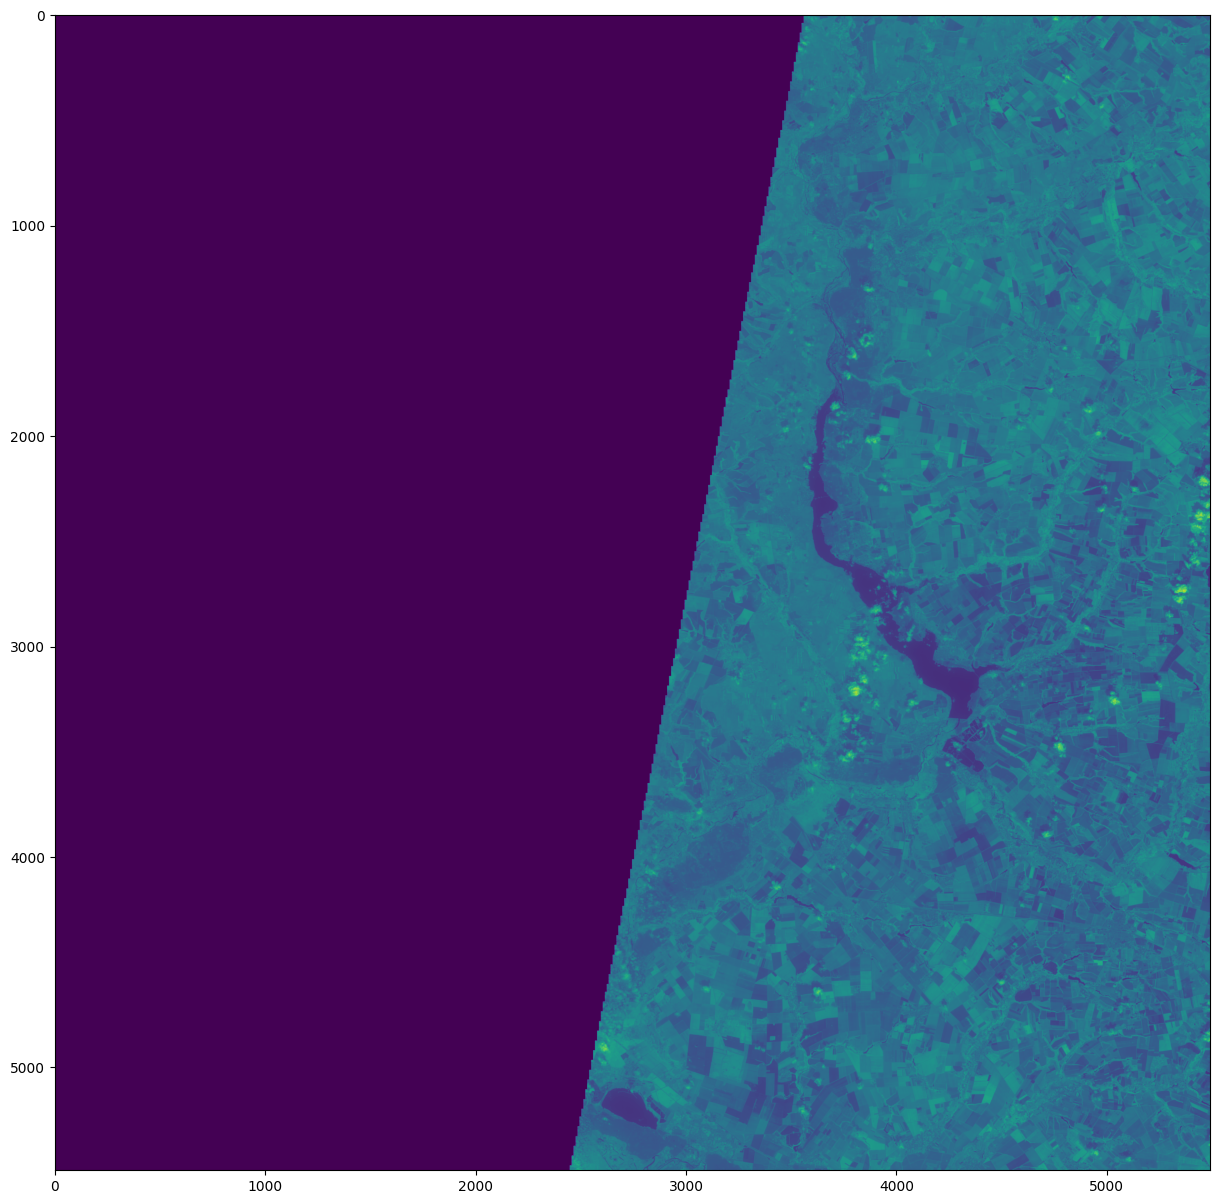

In [248]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [249]:
train_df = gpd.read_file("deforestation_labels.geojson")
print(len(train_df))
train_df.head(5)

5696


,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.7913 50.17406, 35.79277 50.17354,..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.7781 50.10318,..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."


In [250]:

train_df['geometry'][0].exterior.coords.xy

(array('d', [35.79130110364752, 35.79277364075651, 35.79297457903032, 35.791157474146246, 35.7903885750503, 35.79130110364752]),
 array('d', [50.174056041526406, 50.17353744707388, 50.17264504733532, 50.17247166166292, 50.17287983873138, 50.174056041526406]))

In [251]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 5696 files


In [252]:
train_df = gpd.read_file("deforestation_labels.geojson")

train_df = train_df[train_df.geometry.notnull()]

train_df.crs = {'init' :'epsg:3395'}

train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

/Users/yanakravets/DS_Internship/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [253]:

src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "Task2/S2A_MSIL1C_20160618T082602_N0204_R021_T36UYA_20160618T083357.SAFE/GRANULE/L1C_T36UYA_A005166_20160618T083357/IMG_DATA"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['Field_Id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 5696 files


Number of polygons: 5698
Unique values in mask: [0]


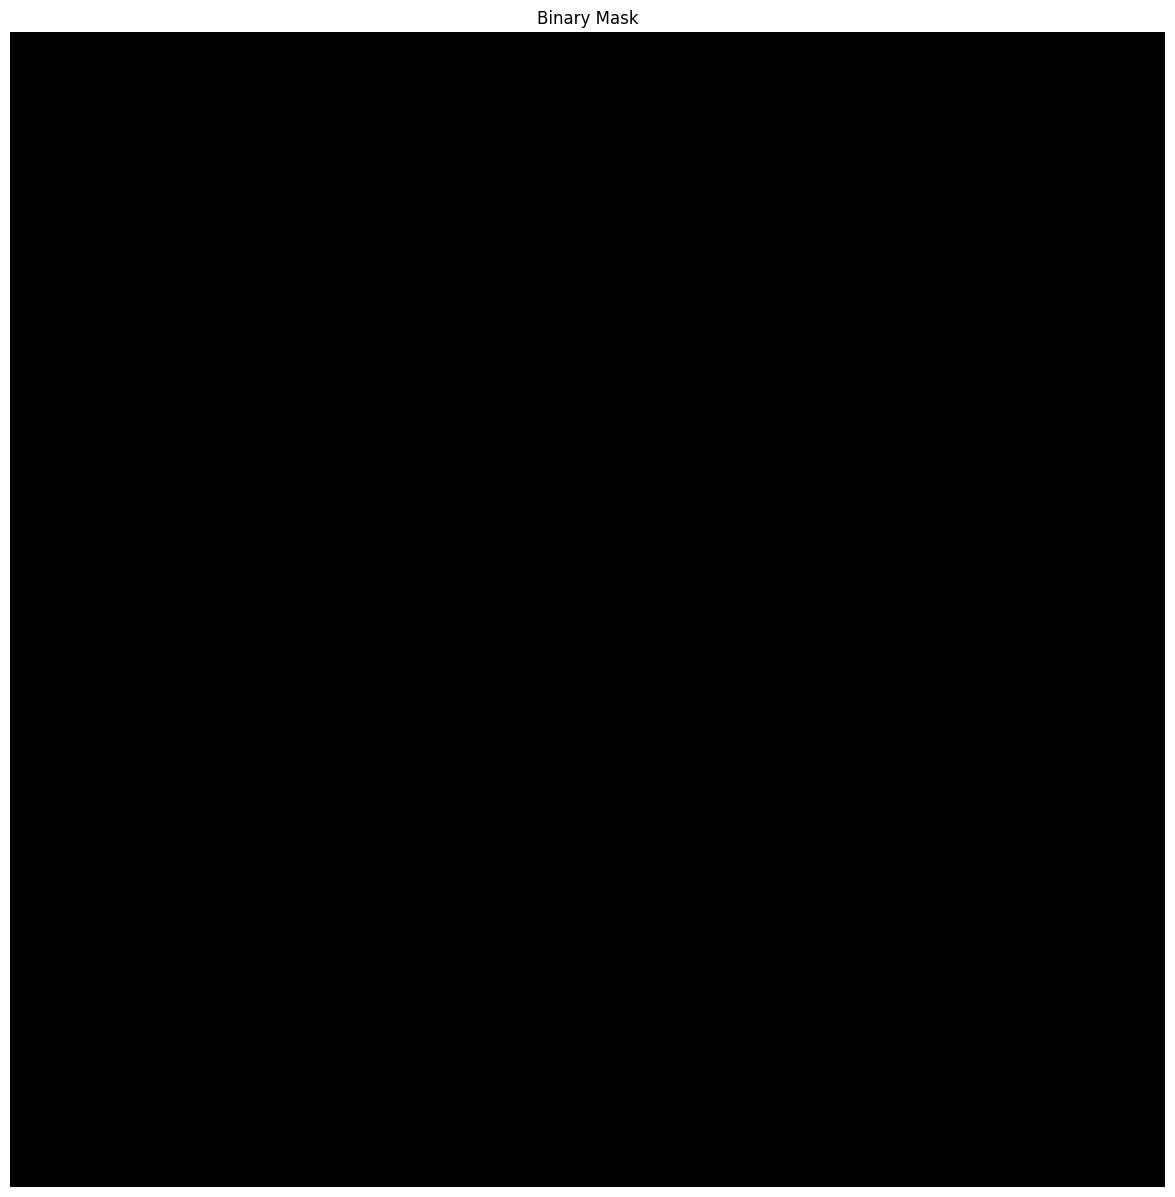

In [254]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        x, y = i[0], i[1]
        transformed_x = transform[0] * x + transform[1] * y + transform[2]
        transformed_y = transform[3] * x + transform[4] * y + transform[5]
        
        poly_pts.append((transformed_x, transformed_y))
        
    new_poly = Polygon(poly_pts)
    return new_poly

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])

for num, row in train_df.iterrows():
    geom = row['geometry']
    if geom.geom_type == 'Polygon':
        poly = poly_from_utm(geom, src.meta['transform'])
        poly_shp.append(poly)
    elif geom.geom_type == 'MultiPolygon':
        for p in geom.geoms:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

print(f'Number of polygons: {len(poly_shp)}') 

mask = rasterize(shapes=poly_shp, out_shape=im_size, fill=0, all_touched=True)

print(f'Unique values in mask: {np.unique(mask)}')

plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1) 
plt.title('Binary Mask')
plt.axis('off')
plt.show()
